In [1]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels as sm
import ingest_ir
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score

In [26]:
FLOPP_files = glob.glob("Datasets for Microplastics\FLOPP and FLOPP-e\FLOPP .csv\*")
FLOPPe_files = glob.glob("Datasets for Microplastics\FLOPP and FLOPP-e\FLOPP-e .csv\*")

In [16]:
cotton1 = pd.read_csv("Datasets for Microplastics/FLOPP and FLOPP-e/FLOPP-e .csv/Cotton 1. Black Fiber.CSV",header=None)
cotton9 = pd.read_csv("Datasets for Microplastics/FLOPP and FLOPP-e/FLOPP .csv/Cotton 9. Black Fiber.CSV",header=None)

In [17]:
cotton1

,0,1
0,399.2094,0.0000
1,401.1380,0.0000
2,403.0665,0.0000
3,404.9951,0.0000
4,406.9236,0.0000
...,...,...
1864,3994.0230,105.2464
1865,3995.9510,105.1591
1866,3997.8800,104.9970
1867,3999.8090,105.0917


In [18]:
cotton9

,0,1
0,399.2094,0.0000
1,401.1380,0.0000
2,403.0665,0.0000
3,404.9951,0.0000
4,406.9236,0.0000
...,...,...
1864,3994.0230,100.9949
1865,3995.9510,100.9781
1866,3997.8800,100.9959
1867,3999.8090,101.0375


<Axes: xlabel='0', ylabel='1'>

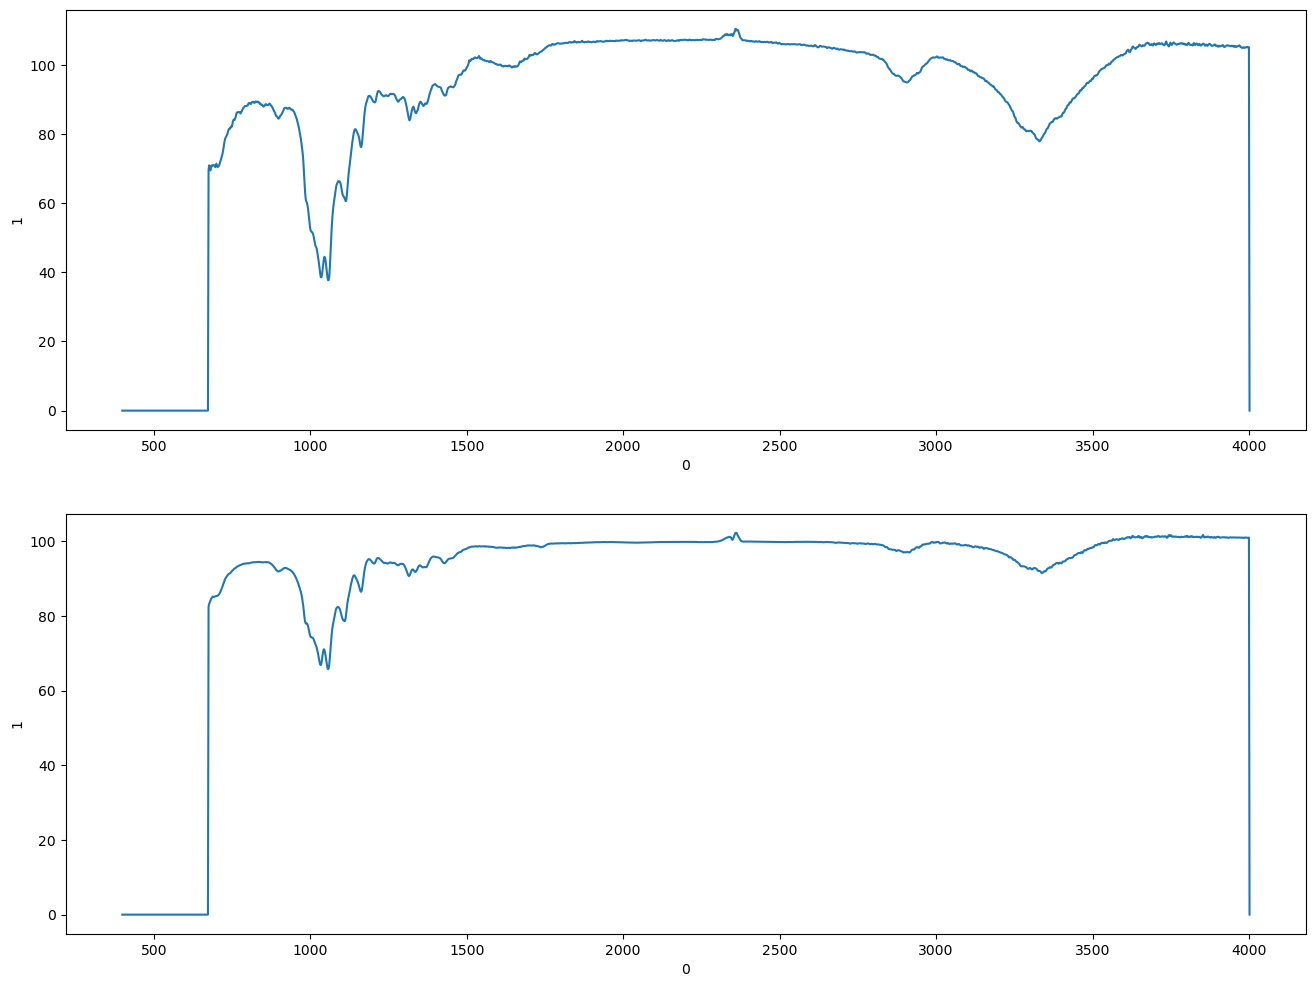

In [19]:
fig, ax = plt.subplots(nrows=2,figsize=(16,12))
sns.lineplot(x=cotton1[0], y=cotton1[1],ax=ax[0])
sns.lineplot(x=cotton9[0], y=cotton9[1],ax=ax[1])

AttributeError: 'list' object has no attribute 'split'

In [29]:
FLOPP_FLOPPe_files = pd.DataFrame(FLOPP_files+FLOPPe_files,columns=['Filepaths'])
FLOPP_FLOPPe_files

,Filepaths
0,Datasets for Microplastics\FLOPP and FLOPP-e\F...
1,Datasets for Microplastics\FLOPP and FLOPP-e\F...
2,Datasets for Microplastics\FLOPP and FLOPP-e\F...
3,Datasets for Microplastics\FLOPP and FLOPP-e\F...
4,Datasets for Microplastics\FLOPP and FLOPP-e\F...
...,...
376,Datasets for Microplastics\FLOPP and FLOPP-e\F...
377,Datasets for Microplastics\FLOPP and FLOPP-e\F...
378,Datasets for Microplastics\FLOPP and FLOPP-e\F...
379,Datasets for Microplastics\FLOPP and FLOPP-e\F...


In [46]:
FLOPP_FLOPPe_files=FLOPP_FLOPPe_files.apply(str.split('\\'))

AttributeError: '\' is not a valid function for 'Series' object

In [110]:
def ingest_single_spectrum_file(filepath, material=None, file_type='csv'):
    if material is str:
        material_label = material
    else:
        material_label = filepath.split('/')[-1][0:-(len(file_type)+1)]

    print(f'material label:{material_label}')    

    if file_type == 'csv':
        spectrum_df = pd.read_csv(filepath, header=None)
        height, width = spectrum_df.shape

        print(f'file shape: {spectrum_df.shape}')

        if width > height:
            spectrum_df = spectrum_df.T
            print('row format detected and converted to column format')
        else:
            print('column format detected')

        for col in spectrum_df.columns:
            print(col)

            spectrum_df[col] = pd.to_numeric(spectrum_df[col], errors='coerce')

            if (spectrum_df[col].isnull().all()) or (pd.Series([spectrum_df[col] is int]).all()): # drop text or index columns, could break if a text column happened to contain a number.
                spectrum_df = spectrum_df.drop(columns=col)
                print("dropped")
            elif any(spectrum_df[col] > 200):
                spectrum_df = spectrum_df.rename(columns={col:"wavenumber"})
                print('wavenumber detected')
            elif any(spectrum_df[col] > 2):
                spectrum_df[col] = spectrum_df[col]/100 # scaling down from %T or %A to just T or A
                spectrum_df = spectrum_df.rename(columns={col:'measurement'})
                print('measurement percentage detected and converted')
            else:
                spectrum_df = spectrum_df.rename(columns={col:'measurement'})
                spectrum_df = print('measurement detected')

        assert len(spectrum_df.columns) == 2 # check that we're down to just our two desired columns
        print(f'found: {list(spectrum_df.columns)}')

        spectrum_df = spectrum_df.dropna() # get rid of text or missing-data rows

        spectrum_df = spectrum_df.drop([0,1],axis=0) # remove any padding - real measurements are never exactly 0 or 1
        
        if np.mean(spectrum_df['measurement']) > 0.5: # Check for T
            spectrum_df['measurement'] = 1 - spectrum_df['measurement'] # Convert to A
            print('T detected, converted to A')
        else:
            print('A detected, no conversion needed')

        return material_label, spectrum_df['wavenumber'], spectrum_df['measurement'] # material or file name, wavenumbers, and A

    else:
        return "Current supported filetypes are: csv only"

In [111]:
ingest_single_spectrum_file('Datasets for Microplastics/FLOPP and FLOPP-e/FLOPP .csv/ABS 11. Black LEGO Fragment.CSV')

material label:ABS 11. Black LEGO Fragment
file shape: (1869, 2)
column format detected
0
wavenumber detected
1
measurement percentage detected and converted
found: ['wavenumber', 'measurement']
T detected, converted to A


('ABS 11. Black LEGO Fragment',
 2        403.0665
 3        404.9951
 4        406.9236
 5        408.8522
 6        410.7807
           ...    
 1864    3994.0230
 1865    3995.9510
 1866    3997.8800
 1867    3999.8090
 1868    4001.7370
 Name: wavenumber, Length: 1867, dtype: float64,
 2       1.000000
 3       1.000000
 4       1.000000
 5       1.000000
 6       1.000000
           ...   
 1864    0.002002
 1865    0.002371
 1866    0.002621
 1867    0.002575
 1868    1.000000
 Name: measurement, Length: 1867, dtype: float64)